Using TensorFlow backend.


step 1: elapsed 0.7416889667510986
step 2: elapsed 0.0056269168853759766
step 3: elapsed 0.36496639251708984
-------------------------------------------
Handle transitivity:
	Intra:		 179
	Intra(choice):	 9
	Inter:		 958
	Inter(choice):	 227
-------------------------------------------
	Time =  150516  ms
	result: 0

	Total cost: 163.47345704217764

# valid points:		 53
# invalid points:	 12
step 4: elapsed 150.52352619171143
step 5: elapsed 0.0023131370544433594
elapsed 151.6395571231842
#Humans 1


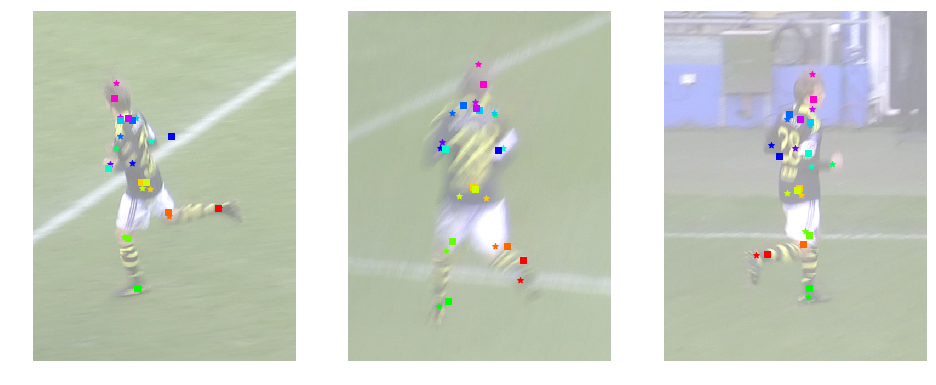

In [1]:
%matplotlib inline
# ------------------
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# ------------------
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
import numpy as np
import cv2
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth
from mvpose import pose
import paf_loader

from mvpose.algorithm import settings

params = settings.get_settings(scale_to_mm=1000,
                               min_nbr_joints=5,
                               max_epi_distance=25)

colors = cs.lincolor(16).astype('float32')/255
FRAME = 9 # 85
data_root = Settings['data_root']
#seq1_zipname = 'player1sequence2.zip'
#seq1_dir = 'Sequence 2'
seq1_zipname = 'player2sequence1.zip'
seq1_dir = 'Sequence 1'
Im, Calib, pos2d, pos3d = kth.get(
    data_root, seq1_zipname, seq1_dir, FRAME, player=2)


from mvpose.algorithm.candidate_selection import project_human_to_2d

heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, FRAME, dir=Settings['tmp'])
_start = time()
Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=params, debug=True)
_end = time()
print('elapsed', _end - _start)

Humans = kth.transform3d_from_mscoco(detections)
print('#Humans', len(Humans))

fig = plt.figure(figsize=(16,10))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3,cid+1); ax.axis('off')
    ax.imshow(im, alpha=0.5)
    joints = pos2d[:,:,cid]
    for jid, (x,y) in enumerate(joints):
        ax.scatter(x,y,color=colors[jid], marker='*')

    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, Calib[cid])
        for jid, p in enumerate(human2d):
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[jid], marker='s')

plt.show()

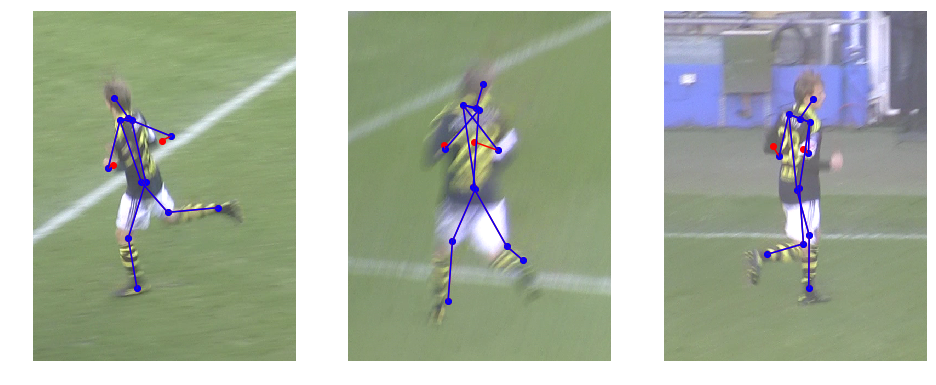

In [ ]:
import mvpose.data.skeleton_augmentation as ska
model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, params.scale_to_mm)

detections = gen.apply(detections)
Humans2 = kth.transform3d_from_mscoco(detections)

fig = plt.figure(figsize=(16,10))

colors = cs.lincolor(5).astype('float32')/255

for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3,cid+1); ax.axis('off')
    ax.imshow(im, alpha=0.8)
    
    for pid, human in enumerate(Humans2):
        kth.draw_limbs2d(ax, human, Calib[cid], color='red', print_length=False)
    
    for pid, human in enumerate(Humans):
        kth.draw_limbs2d(ax, human, Calib[cid], color="blue", print_length=False)
    
        
plt.show()

In [ ]:
from mvpose.evaluation import pcp

model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, params.scale_to_mm)
use_heuristic = False

# =======================================================
def extract_best(pos3d, Humans, alpha):
    larms = 0
    uarms = 0
    ulegs = 0
    llegs = 0
    all_parts = 0
    pelvis = 0
    
    for h in Humans:
        r = pcp.evaluate(pos3d, Humans[0], alpha)
        if all_parts < r.all_parts:
            larms = r.lower_arms
            uarms = r.upper_arms
            ulegs = r.upper_legs
            llegs = r.lower_legs
            pelvis = r.pelvis
            all_parts = r.all_parts
    
    return {
        "larms": larms,
        "uarms": uarms,
        "ulegs": ulegs,
        "llegs": llegs,
        "pelvis": pelvis,
        "all_parts": all_parts
    }

# =======================================================
def apply(frame, use_heuristic=False, alpha = 0.5):
    """
    """
    Im, Calib, pos2d, pos3d = kth.get(
        data_root, seq1_zipname, seq1_dir, frame, player=2)
    heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
        'kth' + seq1_zipname[0:-4], Im, frame, dir=Settings['tmp'])
    
    if use_heuristic:
        detections = pose.estimate_heuristic(
            Calib, heatmaps, pafs, settings=params)
    else:
        detections = pose.estimate(
            Calib, heatmaps, pafs, settings=params)
        
    
    Humans = kth.transform3d_from_mscoco(detections)
    result1 = extract_best(pos3d, Humans, alpha)
    
    # ---------------------------------
    
    
    detections = gen.apply(detections)
    Humans = kth.transform3d_from_mscoco(detections)
    result2 = extract_best(pos3d, Humans, alpha)
    
    del Im
    del Calib
    del pos2d
    del pos3d
    del heatmaps
    del pafs
    
    return result1, result2
    
    
    
# =======================================================

larms = []
uarms = []
llegs = []
ulegs = []
pelvis = []
shoulder = []
head = []
all_parts = []

larms_ex = []
uarms_ex = []
llegs_ex = []
ulegs_ex = []
pelvis_ex = []
shoulder_ex = []
head_ex = []
all_parts_ex = []

for frame in range(0, 214, 1):
    _start = time()
    
    result, result_ex = apply(frame, use_heuristic=use_heuristic)
    
    larms.append(result['larms'])
    uarms.append(result['uarms'])
    llegs.append(result['llegs'])
    ulegs.append(result['ulegs'])
    pelvis.append(result['pelvis'])
    all_parts.append(result['all_parts'])
    
    larms_ex.append(result_ex['larms'])
    uarms_ex.append(result_ex['uarms'])
    llegs_ex.append(result_ex['llegs'])
    ulegs_ex.append(result_ex['ulegs'])
    pelvis_ex.append(result_ex['pelvis'])
    all_parts_ex.append(result_ex['all_parts'])
    
    
    _end = time()
    print('frame ' + str(frame) + ', elapsed', _end - _start)

frame 0, elapsed 4.296788215637207
frame 1, elapsed 8.504429340362549
frame 2, elapsed 72.58366417884827
frame 3, elapsed 1259.6282794475555


In [ ]:
print('+++ No limb heuristic +++')
print('lower arms:\t', np.mean(larms))
print('upper arms:\t', np.mean(uarms))
print('lower legs:\t', np.mean(llegs))
print('upper legs:\t', np.mean(ulegs))
print('pelvis:\t\t', np.mean(pelvis))
print('shoulder:\t', np.mean(shoulder))
print('head:\t\t', np.mean(head))
print('all parts:\t', np.mean(all_parts))

print('+++ With limb heuristic +++')
print('lower arms:\t', np.mean(larms_ex))
print('upper arms:\t', np.mean(uarms_ex))
print('lower legs:\t', np.mean(llegs_ex))
print('upper legs:\t', np.mean(ulegs_ex))
print('pelvis:\t\t', np.mean(pelvis_ex))
print('shoulder:\t', np.mean(shoulder_ex))
print('head:\t\t', np.mean(head_ex))
print('all parts:\t', np.mean(all_parts_ex))

In [ ]:
plt.plot(range(len(larms_ex)), larms_ex)

Due to "unelegant" programming we had to run the evaluation in batches

In [ ]:
avg_lower_arms_0_to_100 = 0.52
avg_upper_arms_0_to_100 = 0.77
avg_lower_legs_0_to_100 = 0.625
avg_upper_legs_0_to_100 = 0.745

avg_lower_arms_0_to_100_h = 0.705
avg_upper_arms_0_to_100_h = 0.865
avg_lower_legs_0_to_100_h = 0.77
avg_upper_legs_0_to_100_h = 0.845

In [ ]:
avg_lower_arms_100_to_200 = 0.785
avg_upper_arms_100_to_200 = 0.87
avg_lower_legs_100_to_200 = 0.71
avg_upper_legs_100_to_200 = 0.835

avg_lower_arms_100_to_200_h = 0.845
avg_upper_arms_100_to_200_h = 0.97
avg_lower_legs_100_to_200_h = 0.825
avg_upper_legs_100_to_200_h = 0.92

In [ ]:
avg_lower_arms_200_to_214 = 0.68
avg_upper_arms_200_to_214 = 0.75
avg_lower_legs_200_to_214 = 0.5
avg_upper_legs_200_to_214 = 0.643

avg_lower_arms_200_to_214_h = 0.82
avg_upper_arms_200_to_214_h = 0.92
avg_lower_legs_200_to_214_h = 0.75
avg_upper_legs_200_to_214_h = 0.893

In [ ]:
lower_arms = [avg_lower_arms_0_to_100, 
              avg_lower_arms_100_to_200,
              avg_lower_arms_200_to_214]

upper_arms = [avg_upper_arms_0_to_100,
              avg_upper_arms_100_to_200,
              avg_upper_arms_200_to_214]

lower_legs = [avg_lower_legs_0_to_100,
              avg_lower_legs_100_to_200,
              avg_lower_legs_200_to_214]

upper_legs = [avg_upper_legs_0_to_100,
              avg_upper_legs_100_to_200,
              avg_upper_legs_200_to_214]
N = [lower_arms,upper_arms,lower_legs,upper_legs]

# =========================

lower_arms_h = [avg_lower_arms_0_to_100_h, 
              avg_lower_arms_100_to_200_h,
              avg_lower_arms_200_to_214_h]

upper_arms_h = [avg_upper_arms_0_to_100_h,
              avg_upper_arms_100_to_200_h,
              avg_upper_arms_200_to_214_h]

lower_legs_h = [avg_lower_legs_0_to_100_h,
              avg_lower_legs_100_to_200_h,
              avg_lower_legs_200_to_214_h]

upper_legs_h = [avg_upper_legs_0_to_100_h,
              avg_upper_legs_100_to_200_h,
              avg_upper_legs_200_to_214_h]
H = [lower_arms_h,upper_arms_h,lower_legs_h,upper_legs_h]

# =========================
Factors = [100/214, 100/214, 14/214]


print("lower arms:\t", np.sum(np.multiply(lower_arms, Factors)))
print("upper arms:\t", np.sum(np.multiply(upper_arms, Factors)))
print("lower legs:\t", np.sum(np.multiply(lower_legs, Factors)))
print("upper legs:\t", np.sum(np.multiply(upper_legs, Factors)))
print('avg:\t\t', np.mean([np.sum(np.multiply(A, Factors)) for A in N]))
print()
print("lower arms+h:\t", np.sum(np.multiply(lower_arms_h, Factors)))
print("upper arms+h:\t", np.sum(np.multiply(upper_arms_h, Factors)))
print("lower legs+h:\t", np.sum(np.multiply(lower_legs_h, Factors)))
print("upper legs+h:\t", np.sum(np.multiply(upper_legs_h, Factors)))
print('avg:\t\t', np.mean([np.sum(np.multiply(A, Factors)) for A in H]))